<a href="https://colab.research.google.com/github/AShipulin/Train-Scheduler-Simulator-SimPy/blob/main/TrainSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# График движения поездов

График движения поездов строится с использованием дискретно-событийного имитационного моделирования.

Для построения используется библиотека SimPy.
В библиотеке существую "общие ресурсы" (PriorityResource), что подходит для принципов построения.

SimPy. Discrete event simulation for Python
* https://simpy.readthedocs.io/en/latest/
* https://pypi.org/project/simpy/
* https://gitlab.com/team-simpy/simpy/

Since you can easily forget this, all resources events are context managers (see the Python docs for details).

Примеры моделей:
- https://github.com/sisl/event-driven-rllab/blob/932d6cc0911071443d1d43277ee011f4d832631e/FirestormProject/OldEnvs/traffic_light_env.py#L99

## Описание

Однопутный участок из станйий s1, ...,sN и трех перегонов p1, ..., pN оброудованых автоблокировкой.

Размерность участка задется в **staN**

При отправлении поездов в повутном направлении учитывается:
- Интервала попутного отправления поездов Iот (тип Х) - IOt
- Интервала попутного прибытия Iпр (тип IX) 3,3...4,3 - IPr

При отправлении поездов во встречном направлении учитывается:
- Интервала скрещения τс (тип III) 0,5 - ISc


```
-> Чет.              Неч. <-

                 <- Поезд 2001

IOt11   IOt11    IOt12    IOt13
IPr11   IPr11    IPr12    IPr13
ISc11   ISc11    ISc12    ISc13
s0       s1       s2       s3
    p00       p01       p02
|---------|---------|---------|
    p10       p11       p12
ISc00   ISc01    ISc02    ISc03
IPr00   IPr01    IPr02    IPr03
IOt00   IOt01    IOt02    IOt03


Поеезд 2002 ->
```

В будщем нудно учесть:
- Приоритеты (очередность) поездов
- Время хода между станциями
- Время на рзгон
- Время на замедление
- Полуавтоблокирку
- Двухпутный и многопутные учаскти
- Дифиренсацию интервла для разных категорий поездов
- Количесто путей на станции для четных / нечетных поездов

Справочно:

- Полуавтоблокирка - обспечивает нахождение одного поезда на пути перегона.
В попутном направлении поезда отправляются с интервалом попутного следования. Во встречном направлении поезда отправляются с итервалом скрещения поездов.


## Установка simpy и необходимых библиотк

In [1]:
!pip install -U simpy
import simpy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

## Отрисовываем график движения поездов

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Графики занятости ресурсов
def show_res_busy(ax, x_max, title, resType, df_resQueue):
    ax.set_title(title)
    ax.set_xlim([0, x_max])
    ax.grid(True)
    for sp in ['top', 'bottom', 'right', 'left']:
        ax.spines[sp].set_visible(False)
    df = df_resQueue[(df_resQueue.dir == 0) & (df_resQueue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']+.2, df['sta']+.2], c='b', lw=5)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='b', ax=ax)
    df = df_resQueue[(df_resQueue.dir == 1) & (df_resQueue.res == resType)]
    ax.plot([df['time']-.1, df['time']+.1], [df['sta']-.2, df['sta']-.2], c='r', lw=5)
    #df.plot(kind='scatter', x='time', y='sta', s=32, c='r', ax=ax)

# Отрисовываем график движения поездов
def show_gts(train_schedule, log_queue, fs_width = 10, fs_height = 8):

    # Добавляем колонки в resQueue
    df_log_queue = pd.DataFrame(log_queue, columns=["res", "time", "dir", "sta", "cnt", "len"])
    df_log_queue = df_log_queue[(df_log_queue.cnt == 1)]
    df_log_queue['c'] = np.where(df_log_queue['dir'] == 1, 'r', 'g')

    # Добавим имена колонок
    df_train_schedule = pd.DataFrame(train_schedule, columns=["train", "sta", "time"])
    x_max = df_train_schedule['time'].max()  # Максимальное время

    # Создайте фигуру, содержащую одну ось
    fig, ax = plt.subplots(5, 1, figsize=(fs_width, fs_height), gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})
    fig.tight_layout(h_pad=2)

    # Оси времени
    time_max = df_train_schedule['time'].max()
    ax[0].set_xlim([0, x_max])
    for i in range(10, time_max, 10):
        if i % 30 > 0:
            ax[0].axvline(x=i, linewidth=1)
    for i in range(30, time_max, 30):
        if i % 60 > 0:
            ax[0].axvline(x=i, linestyle='--', linewidth=1)
    for i in range(0, time_max, 60):
        ax[0].axvline(x=i, linestyle='-', linewidth=2)

    # Оси станций
    df_sta = df_train_schedule.drop_duplicates(subset=['sta'])
    plt.yticks(df_sta['sta'])
    ax[0].get_yaxis().set_ticks(df_sta['sta'])
    ax[1].get_yaxis().set_ticks(df_sta['sta'])
    ax[2].get_yaxis().set_ticks(df_sta['sta'])
    ax[3].get_yaxis().set_ticks(df_sta['sta'])
    ax[4].get_yaxis().set_ticks(df_sta['sta'])
    for index, row in df_sta.iterrows():
        ax[0].axhline(y=row['sta'])
        ax[1].axhline(y=row['sta'])
        ax[2].axhline(y=row['sta'])
        ax[3].axhline(y=row['sta'])
        ax[4].axhline(y=row['sta'])

    # Подписи
    # plt.xlabel('Время, x')
    # plt.ylabel('Станции, y')
    # plt.title("График движения поездов")
    ax[0].set_ylabel('Станции, y')
    ax[0].set_title("График движения поездов")

    # Отключаем линии
    for sp in ['top', 'bottom', 'right', 'left']:
        ax[0].spines[sp].set_visible(False)

    # Рисуем нитки поездов
    df_train = df_train_schedule.groupby(['train']).first()
    for train, row in df_train.iterrows():
        t = df_train_schedule[(df_train_schedule['train'] == train)]
        y = t['sta']
        x = t['time']
        ax[0].plot(x, y, label=train, color='black' if train > 999 else 'red')
        # ax[0].text(row['time'], row['sta'], train)
        if train % 2 == 1:
            ax[0].text(row['time'] - 1, row['sta'] + .2, train)  # , rotation=-75.)
        else:
            ax[0].text(row['time'] - 1, row['sta'] - .2, train)  # , rotation=75.)
        # ax[0].legend()

    # Занятость пути перегона RWay
    show_res_busy(ax[1], x_max, 'Занятость пути перегона RWay', 'Way', df_log_queue)

    # Интервала скрещения τс (тип III) 0,5 - ISc
    show_res_busy(ax[2], x_max, 'Интервала скрещения τс (тип III) 0,5 - ISc', 'ISc', df_log_queue)

    # Интервала попутного отправления поездов Iот (тип Х) - IOt
    show_res_busy(ax[3], x_max, 'Интервала попутного отправления Iот (тип Х) (3,25...7,25)', 'IOt', df_log_queue)

    # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3
    show_res_busy(ax[4], x_max, 'Интервала попутного прибытия Iпр (тип IX) 3,3...4,3', 'IPr', df_log_queue)

    ax[4].set_xlabel('Время, x')

    plt.show()

try:
    show_gts(train_schedule, log_queue, fs_width = 5, fs_height = 9)
except Exception as err:
    print(type(err))
    print(err.args)
    print(err)

<class 'NameError'>
("name 'train_schedule' is not defined",)
name 'train_schedule' is not defined


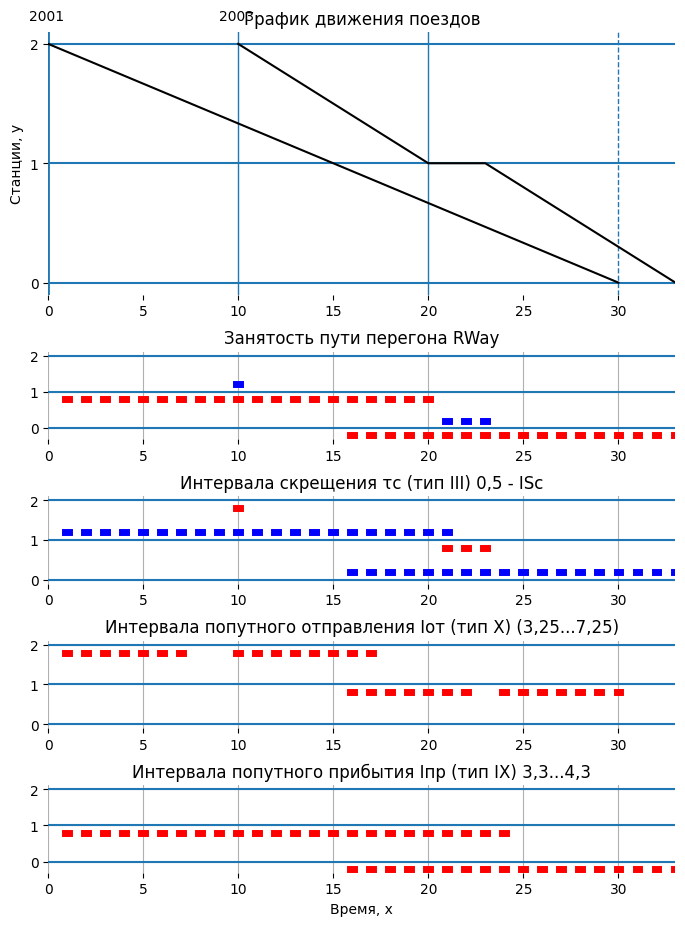

,put,oper,proc,cnt,que
0,15,request,0x78946c108670,0,0
1,15,release,0x78946c108670,1,0
2,20,request,0x78946c10ab90,0,0
3,23,release,0x78946c10ab90,1,0
4,30,release,0x78946c108670,0,0
5,33,release,0x78946c10ab90,0,0


In [211]:
class PriorityResource(simpy.PriorityResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

class PreemptiveResource(simpy.PreemptiveResource):

    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        self.data.append((self._env.now, 'request', p, self.count, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        p = str(self._env.active_process).split('>')[0].split()[3]
        #self._env.active_process.target._delay
        self.data.append((self._env.now, 'release', p, self.count, len(self.queue)))
        return super().release(*args, **kwargs)

class TrainSchedule:

    log_data = [] # Таблица графика движения (человекочитаемая)
    way_busy = {} # Замедление, занятость перегонов

    # Инициализация
    def __init__(self, env, sta_cnt = 4, until=1440, t_i_ot = 8, t_i_pr = 5, t_i_sc = 1):
        self.env = env
        self.sta_cnt = sta_cnt
        self.train_schedule = []
        self.log_queue = []
        self.res_release = []
        self.until = until # Предельная задержка
        self.res_way_s = self.res_add(PreemptiveResource, i=2, n = sta_cnt - 1)
        self.res_i_ot_s = self.res_add(PreemptiveResource, i=2, n = sta_cnt)
        self.res_i_pr_s = self.res_add(PreemptiveResource, i=2, n = sta_cnt)
        self.res_i_sc_s = self.res_add(PreemptiveResource, i=2, n = sta_cnt)
        self.t_i_ot = t_i_ot # Интервала попутного отправления Iот (тип Х) (3,25...7,25) - 8
        self.t_i_pr = t_i_pr # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3 - 5
        self.t_i_sc = t_i_sc # Интервала скрещения τс (тип III) 0,5 - 1
        self.run_proc()

    # Запускаем вспомогательные процессы
    def run_proc(self):

        # Лог занятия ресурсов
        self.env.process(self.queue_logger())

        # Освобождение ресурсов
        self.env.process(self.queue_exec())

    # Генерация ресурсов
    def res_add(self, res, i, n):
        t = ()
        for d in range(i):
            l = []
            for r in range(n):
                l.append(res(self.env, capacity=1))
            t = t + (l,)
        return t

    # Освобождение ресурсов по расписанию
    def queue_exec(self, t_step=1):
        while True:
            for i in range(len(self.res_release)):
                if self.res_release[i][0] == self.env.now:
                    res = self.res_release[i][1]
                    req = self.res_release[i][2]
                    res.release(req)
            yield self.env.timeout(t_step)

    # Сбор логов по ресурсу
    def queue_logger(self, t_step=1):
        res_list = [['Way', self.res_way_s],
                    ['ISc', self.res_i_sc_s],
                    ['IOt', self.res_i_ot_s],
                    ['IPr', self.res_i_pr_s]]
        while True:
            # Каждый так добавляем
            for r, ress in enumerate(res_list):
                for i_dir, dir in enumerate(ress[1]):
                    for i_res, res in enumerate(dir):
                        item = (
                            ress[0],        # Ресурс (имя)
                            self.env.now,        # Текущее время
                            i_dir,          # Индекс направления
                            i_res,          # Индекс ресурса
                            res.count,      # Емкость очереди
                            len(res.queue)  # Дина очереди
                        )
                        self.log_queue.append(item)
            yield self.env.timeout(t_step)

    # Получение параметро движения
    def get_param(self, sta, mov, dir):

        #mov += random.randint(0, 5)
        sta = sta          # Станция отправления
        t_beg = 1          # Время на разгон
        t_mov = mov        # Время на движение
        t_end = 3          # Время на замедление

        if dir == 1:
            way = sta - 1      # Путь перегона
            sta_next = sta - 1 # Следующая станция
            way_next = way - 1 # Следующий путь перегона
            v = 0              # Встречное направление
            p = 1              # Попутное направление
        else:
            way = sta
            sta_next = sta + 1
            way_next = sta + 1
            v = 1
            p = 0

        res_way_v = self.res_way_s[v][way]  # Встречное направление
        res_way_p = self.res_way_s[p][way]  # Попутное направление
        #resRWay0Next = self.res_way_s[v][way_next] if -1 < way_next else None  # Следующий встречный путь
        #resRWay1Next = self.res_way_s[p][way_next] if -1 < way_next else None  # Следующий встречный путь
        #resRWayNext0 = self.res_way_s[0][way_next] if len(res_way_s) > way_next else None  # Попутный следующий
        #resRWayNext1 = self.res_way_s[1][way_next] if len(res_way_s) > way_next else None  # Встречный следующий

        # Интервал попутного отправления
        res_i_ot_p = self.res_i_ot_s[p][sta]  # Проверяем и занимаем

        # Интервал скрещения занимаем
        res_i_sc_next_v = self.res_i_sc_s[v][sta_next]  # Занимаем на следующей станции для встречных поездов
        res_i_sc_p = self.res_i_sc_s[p][sta]  # Проверяем

        # Интервал попутного прибытия
        res_i_pr_next_p = self.res_i_pr_s[p][sta_next]  # Занимаем на следующей станции для попутных поездов

        return (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
                res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p)

    # Операция движения
    def driving(self, train, wait, prio, sta, mov, dir):

        (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
         res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p) = self.get_param(sta, mov, dir)

        if t_mov < self.t_i_ot: raise ValueError(
            "Ограничение версии. Время хода меньше интервал попутного отправления")

        itrain = str(train).zfill(4) + f" ({sta}-{sta_next})"
        until = self.until
        while until  > 0:

            with res_i_ot_p.request(priority=prio) as req_i_ot_p:

                # Начало движения
                with (res_i_sc_p.request(priority=prio) as req_i_sc_p,
                    res_way_v.request(priority=prio) as req_way_v,
                    res_way_p.request(priority=prio) as req_way_p,
                    res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p):

                    try:
                        # Ожидание отправления
                        put = self.env.now
                        #print('Поезд № %s Ожидание отправления в %s с prio=%s' % (itrain, env.now, prio))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, 'Ожидание отправления', None, None, None, None])

                        # Интервал попутного отправления, ждем
                        # Интервал скрещения, ждем
                        # Встречный путь перегона, ждем
                        yield req_i_ot_p & req_i_sc_p & req_way_v
                        #yield req_i_ot_p & req_i_sc_p
                        #print('Поезд № %s Попытка отправления в %s' % (itrain, env.now))
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка отправления", self.env.now, None, self.env.now - put, None])
                        t_delay_beg = self.env.now - put
                        beg = self.env.now

                        # Интервал скрещения, освобождаем
                        res_i_sc_p.release(req_i_sc_p)

                        # Путь перегона попутный, освобождаем
                        res_way_v.release(req_way_v)

                        # Интервал попутного отправления, выполняем
                        yield self.env.timeout(self.t_i_ot)

                        # Интервал попутного отправления, освобождаем
                        res_i_ot_p.release(req_i_ot_p)

                        # Едем по пути перегона
                        yield self.env.timeout(t_mov - self.t_i_ot)

                        res_i_pr_next_p.release(req_i_pr_next_p)

                        # Интервал попутного прибытия, проверяем (при прибытии должен быть свободен)
                        with (res_i_pr_next_p.request(priority=prio-1) as req_i_pr_next_p):

                            # Ожидание прибытия
                            t_delay_end_put = self.env.now
                            #print('Поезд № %s Ожидание прибытия в %s с priority=%s' % (itrain, env.now, prio))
                            self.log_data.append([train, sta, sta_next, prio, self.env.now, "Ожидание прибытия", beg, None, t_delay_beg, None])

                            # Интервал попутного прибытия, ждем
                            # Путь перегона попутный, ждем
                            yield (req_i_pr_next_p & req_way_p)
                            #yield req_i_pr_next_p
                            #print('Поезд № %s Попытка прибытия в %s' % (itrain, env.now))
                            self.log_data.append([train, sta, sta_next, prio, self.env.now, "Попытка прибытия", beg, self.env.now, t_delay_beg, self.env.now - t_delay_end_put])
                            t_delay_end = self.env.now - t_delay_end_put
                            until = 0

                            # Регистрируем события
                            self.log_data.append([train, sta, sta_next, prio, self.env.now, "Прибытие", beg, self.env.now, t_delay_beg, t_delay_end])
                            self.train_schedule.append([train, sta, beg])
                            self.train_schedule.append([train, sta_next, self.env.now])

                    except simpy.Interrupt as interrupt:
                        by = interrupt.cause.by
                        usage = env.now - interrupt.cause.usage_since
                        until -= usage
                        #print(f'{itrain} Вытеснение операции {by} at {self.env.now} after {usage}')
                        self.log_data.append([train, sta, sta_next, prio, self.env.now, "Прибытие", None, None, None, None])

    # Параллельная операция
    def parallel(self, train,  wait, prio, sta, mov, dir):

        (way, sta_next, way_next, sta_next, t_beg, t_mov, t_end,
         res_way_v, res_way_p, res_i_ot_p, res_i_sc_p, res_i_sc_next_v, res_i_pr_next_p) = self.get_param(sta, mov, dir)

        itrain = str(train).zfill(4) + f" ({sta}-{sta_next})"
        until = self.until
        while until  > 0:

            # Путь перегона поутный
            # Интервал скрещения следующий встречный
            with (res_way_p.request(priority=prio) as req_way_p,
                #res_way_v.request(priority=prio) as req_way_v,
                res_i_sc_next_v.request(priority=prio) as req_i_sc_next_v):

                try:

                    # Путь перегона поутный, ждем
                    #yield (req_way_p & req_way_v)
                    yield (req_way_p)

                    # Путь перегона поутный, освобождаем
                    res_way_p.release(req_way_p)

                    # Интервал попутного прибытия
                    with (res_i_pr_next_p.request(priority=prio) as req_i_pr_next_p):

                        # Интервал скрещения следующий встречный, выполняем
                        yield self.env.timeout(self.t_i_sc)

                        # Интервал скрещения следующий встречный, освобождаем
                        res_i_sc_next_v.release(req_i_sc_next_v)

                        # Интервал попутного прибытия, выполняем
                        yield self.env.timeout(self.t_i_pr - self.t_i_sc)
                        until = 0

                except simpy.Interrupt as interrupt:
                    by = interrupt.cause.by
                    usage = env.now - interrupt.cause.usage_since
                    until = usage
                    #print(f'{itrain} Вытеснение паралельной операции {by} at {self.env.now} after {usage}')
                    self.log_data.append([train, sta, sta_next, prio, self.env.now, "Вытеснение паралельной операции", None, None, None, None])

    # Поезд
    def train(self, train, wait, prio=None, sta = None, mov = None):
        dir = train%2
        if mov == None: mov = round(15.*.7) if train < 1000 else 15
        if sta == None: sta = self.sta_cnt if dir == 1 else 0
        prio = 100 if train < 1000 else 1000
        yield self.env.timeout(wait) # Время отправления поезда
        for s in range(self.sta_cnt-1, 0, -1) if dir == 1 else range(self.sta_cnt-1):
            if s >= sta and dir == 0 or s <= sta and dir == 1:
                op1 = self.env.process(self.driving(train, wait=0, prio=prio, sta=s, mov=mov, dir=dir))
                op2 = self.env.process(self.parallel(train, wait=0, prio=prio, sta=s, mov=mov, dir=dir))
                yield op1

    # Окно
    def window(self, way, wait, dur):
        yield self.env.timeout(wait)
        res0 = self.res_way_s[0][way]
        res1 = self.res_way_s[1][way]
        with res0.request(priority=-1) as req0, res0.request(priority=-1) as req0:
             yield self.env.timeout(dur)


# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
until = 360
ts = TrainSchedule(env = env, sta_cnt = 3, until=until)

'''
# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(0):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(15,30)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=15))
env.process(ts.train(train=103, wait=120))
env.process(ts.train(train=102, wait=60))
env.process(ts.train(train=104, wait=70))
'''

#env.process(ts.train(train=101, wait=15))
#env.process(ts.window(way=2, wait=30, dur=30))

env.process(ts.train(train=2001, wait=0))
env.process(ts.train(train=2003, wait=10, mov=10))

# Выполняем расчет
env.run(until=until)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 7, 9)
#pd.DataFrame(log_data, columns=["train", "sta", "sta_n", "prio", "put", "oper","beg", "end", "d_beg", "d_end"])
pd.DataFrame(ts.res_way_s[0][0].data, columns=["put", "oper", "proc", "cnt", "que"])
#ts.log_queue
#pd.DataFrame(train_schedule, columns=["train", "sta", "time"])
#pd.DataFrame(log_queue, columns=["res", "time", "dir", "sta", "cnt", "len"])

## Интервала скрещения τс (тип III) 0,5

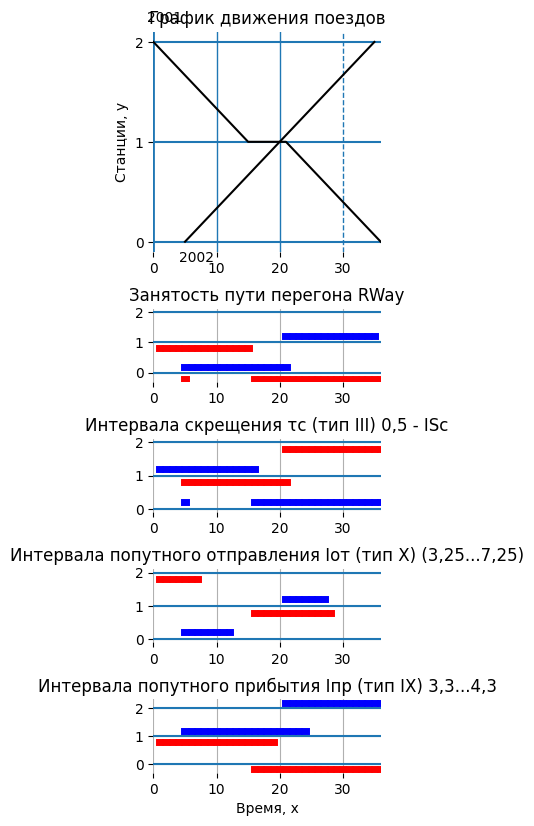

In [206]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 3)

# Интервал скрещения
#t2001 = env.process(ts.train1(train=2001, wait=5, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))
#или
t2001 = env.process(ts.train(train=2001, wait=0, prio=2001))
t2002 = env.process(ts.train(train=2002, wait=5, prio=2002))

# Не работает если отправить в одно время
#t2001 = env.process(ts.train1(train=2001, wait=0, prio=2000))
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## Интервала попутного отправления Iот (тип Х) (3,25...7,25)

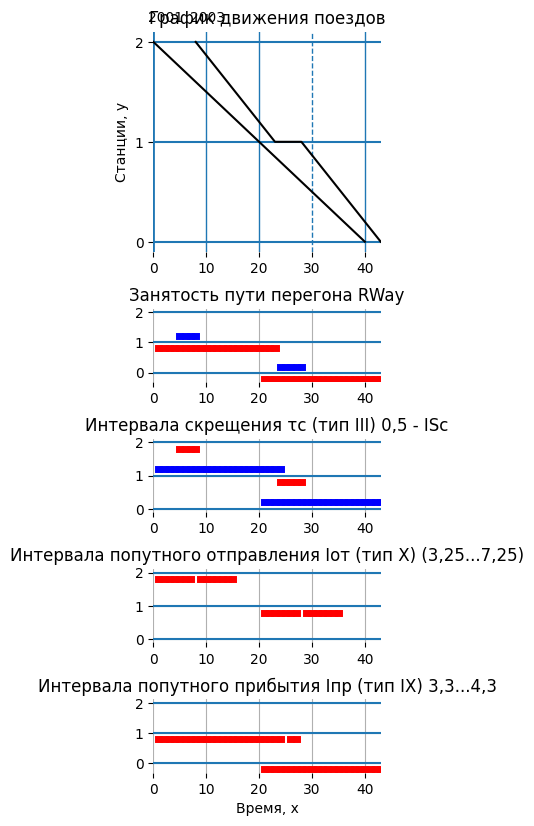

In [207]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 3)

# Интервал попутного отправления
t2001 = env.process(ts.train(train=2001, wait=0, prio=2000, mov=20))
t2003 = env.process(ts.train(train=2003, wait=5, prio=2000, mov=15))
#t2005 = env.process(ts.train1(train=2005, wait=10, prio=2000, mov=10))
# или
#t2002 = env.process(ts.train0(train=2002, wait=0, prio=2000, mov=20))
#t2004 = env.process(ts.train0(train=2004, wait=5, prio=2000))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## # Интервала попутного прибытия Iпр (тип IX) 3,3...4,3

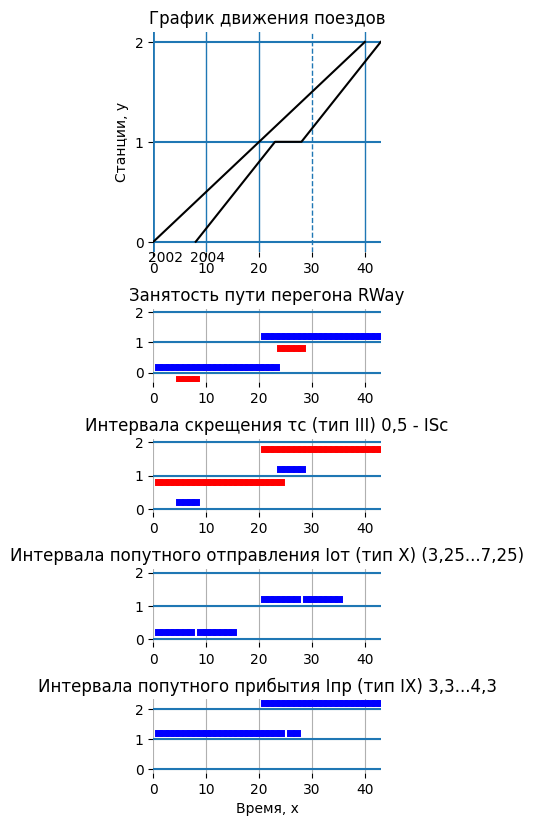

In [208]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 3)

# Интервал попутного прибытия
#t2001 = env.process(ts.train1(train=2001, wait=0, prio=2000, mov=20))
#t2003 = env.process(ts.train1(train=2003, wait=5, prio=2000, mov=10))
#t2005 = env.process(ts.train1(train=2005, wait=10, prio=2000, mov=15))
# или
t2002 = env.process(ts.train(train=2002, wait=0, mov=20))
t2004 = env.process(ts.train(train=2004, wait=5))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
show_gts(ts.train_schedule, ts.log_queue, fs_width = 3, fs_height = 8)

## Обгоны

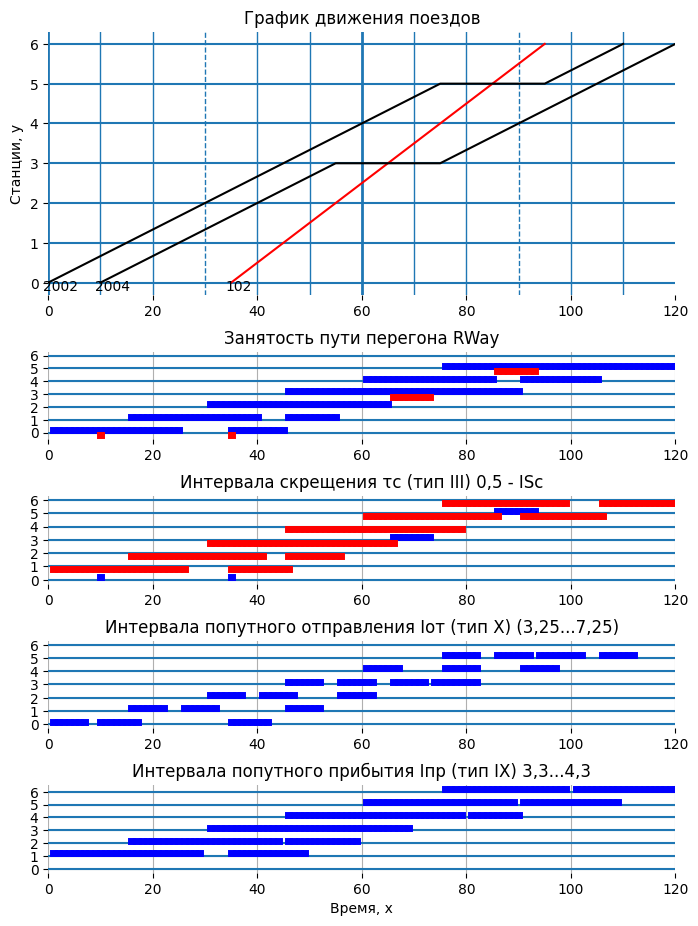

In [209]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 7)

# Приоритеты поездов
# Не можем обогнать поезд. 102 должен обогнать 2004
env.process(ts.train(train=2002, wait=0))
env.process(ts.train(train=2004, wait=10))
env.process(ts.train(train=102, wait=35))

# Выполняем расчет
env.run(until=360)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, fs_width = 7, fs_height = 9)
#ts.log_queue
#pd.DataFrame(log_data, columns=["train", "sta", "sta_n", "put", "beg", "end", "d_beg", "d_end"])

## Много поездов

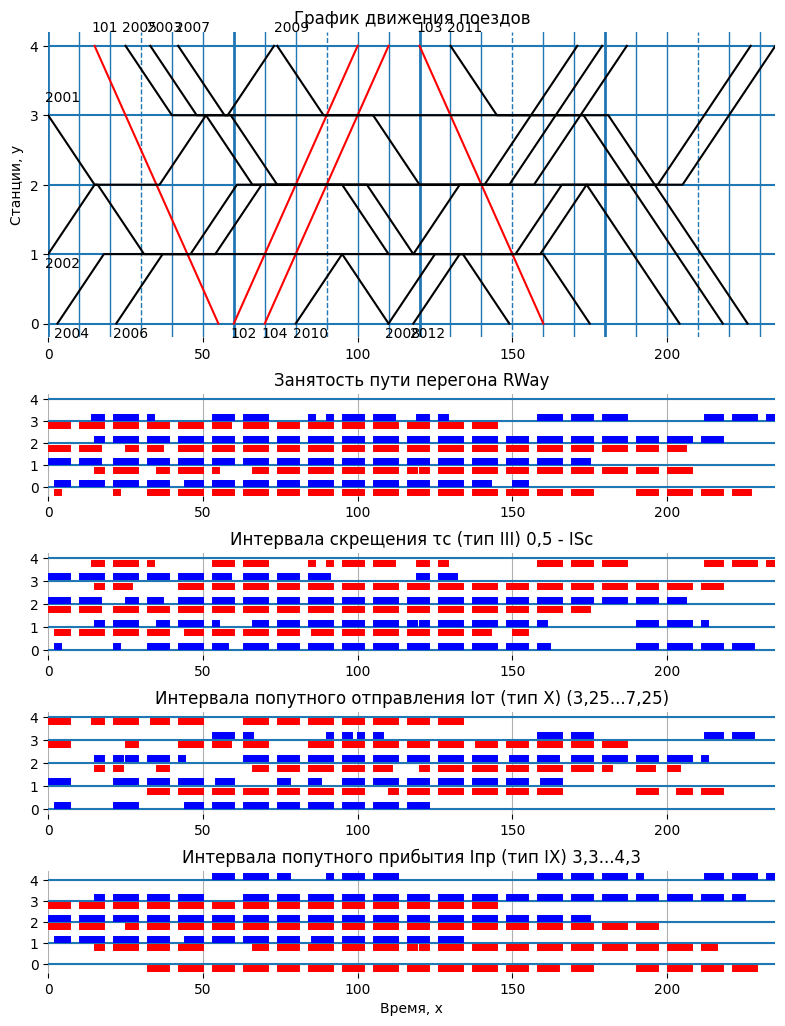

In [210]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 5)

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(15,30)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=15))
env.process(ts.train(train=103, wait=120))
env.process(ts.train(train=102, wait=60))
env.process(ts.train(train=104, wait=70))

# Выполняем расчет
env.run(until=560)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 8, 10)

## Много поездов и окно

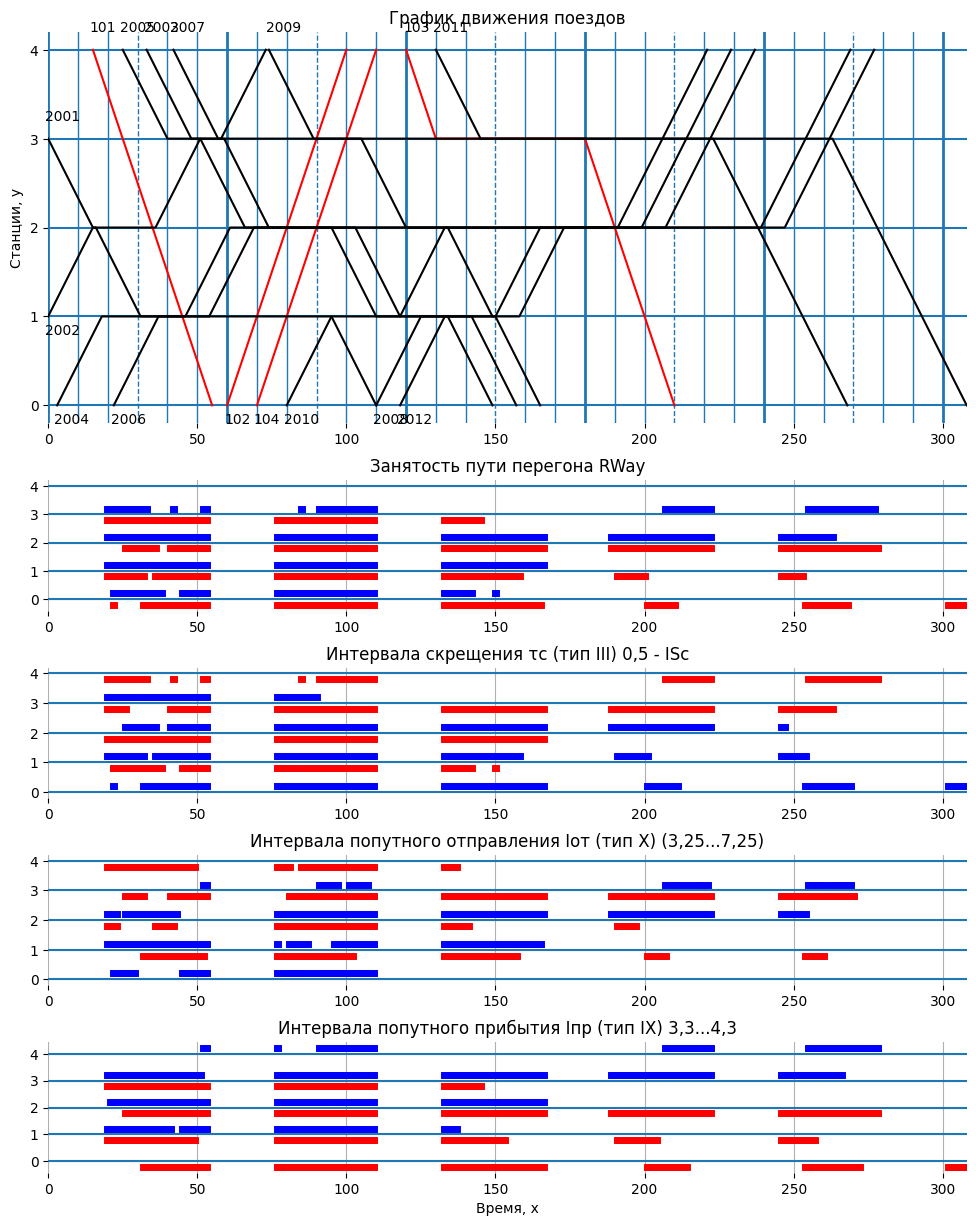

In [214]:
# Получаем среду
env = simpy.Environment()

# Инициируем класс графика движения поездов
ts = TrainSchedule(env = env, sta_cnt = 5)

# Много поездов
random.seed(20)
t, w = 0, 0
for i in range(5):
    env.process(ts.train(train=2003+t, wait=0+w, prio=2000))
    env.process(ts.train(train=2004+t, wait=3+w, prio=2000))
    w += random.randint(15,30)
    t += 2

env.process(ts.train(train=2001, wait=0, sta=3))
env.process(ts.train(train=2002, wait=0, sta=1 ))
env.process(ts.train(train=101, wait=15))
env.process(ts.train(train=103, wait=120))
env.process(ts.train(train=102, wait=60))
env.process(ts.train(train=104, wait=70))

env.process(ts.window(way=2, wait=120, dur=60))

# Выполняем расчет
env.run(until=560)

# Отрисовываем график движения поездов
train_schedule, log_queue, log_data = (ts.train_schedule, ts.log_queue, ts.log_data)
show_gts(train_schedule, log_queue, 10, 12)